## Tratamento dos dados

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Phishing_Email.csv", encoding='latin-1')

df

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...,...
18645,18646,date a lonely housewife always wanted to date ...,Phishing Email
18646,18647,request submitted : access request for anita ....,Safe Email
18647,18648,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18648,18649,press clippings - letter on californian utilit...,Safe Email


In [106]:
df = df.drop(columns=["Unnamed: 0"])
df = df.rename(columns={"Email Text": "texto"})
print(df["Email Type"].value_counts())
print("Total: ", df["Email Type"].value_counts().sum())

Email Type
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64
Total:  18650


In [107]:
df["texto"].replace('empty',np.nan,inplace=True)

C:\Users\Samuel\AppData\Local\Temp\ipykernel_14832\1425109582.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["texto"].replace('empty',np.nan,inplace=True)


In [114]:
df = df.dropna()
print(df.value_counts().sum())
df

18101


,texto,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...
18644,\nRick Moen a ÃÂ©crit:> > I'm confused. I th...,Safe Email
18645,date a lonely housewife always wanted to date ...,Phishing Email
18646,request submitted : access request for anita ....,Safe Email
18647,"re : important - prc mtg hi dorn & john , as y...",Safe Email


In [ ]:
df = df.drop_duplicates(subset='texto', keep='first')
print(df.value_counts().sum())

17536


In [117]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df["Email Type"] = le.fit_transform(df["Email Type"])

C:\Users\Samuel\AppData\Local\Temp\ipykernel_14832\3829774040.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Email Type"] = le.fit_transform(df["Email Type"])


In [118]:
import unicodedata
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.category(c) == 'Mn'])

def remove_stopwords(text):
    words = text.split()
    return " ".join([word for word in words if word not in ENGLISH_STOP_WORDS])

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = remove_accents(text)
    text = remove_stopwords(text)
    return text.strip()

df["texto"] = df["texto"].apply(preprocess_text)

print(df.head())


                                               texto  Email Type
0  6 1100 disc uniformitarianism 1086 sex lang di...           1
1  galicismos galicismo spanish term names improp...           1
2  equistar deal tickets available assist robert ...           1
3  hello hot lil horny toy dream open minded pers...           0
4  software incredibly low prices 86 lower draper...           0


C:\Users\Samuel\AppData\Local\Temp\ipykernel_14832\77995477.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["texto"] = df["texto"].apply(preprocess_text)


In [119]:
from gensim.models import Word2Vec

def word2vec(textos_tokenizados, vector_size=200, window=6, min_count=2):
    model = Word2Vec(
        sentences=textos_tokenizados,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=1,
        workers=4
    )
    return model

def vetor_medio(texto, model):
    palavras = texto.split()
    vetores = [model.wv[p] for p in palavras if p in model.wv]
    if vetores:
        return np.mean(vetores, axis=0)
    else:
        return np.zeros(model.vector_size)

def word2vec_transform(df, model):
    vetores = df["texto"].apply(lambda x: vetor_medio(x, model))
    matriz = np.vstack(vetores.values)

    df_w2v = pd.DataFrame(matriz, columns=[f"w2v_{i}" for i in range(model.vector_size)])
    df_w2v["Email Type"] = df["Email Type"].values

    return df_w2v, model

df["tokens"] = df["texto"].apply(lambda x: x.lower().split())

modelo_w2v = word2vec(df["tokens"].tolist())

df_final, modelo_w2v = word2vec_transform(df, modelo_w2v)

print(df_final.head())


C:\Users\Samuel\AppData\Local\Temp\ipykernel_14832\951628509.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"] = df["texto"].apply(lambda x: x.lower().split())


      w2v_0     w2v_1     w2v_2     w2v_3     w2v_4     w2v_5     w2v_6  \
0  0.109674  0.000218  0.098087  0.057513  0.185959 -0.207520  0.075432   
1  0.197166 -0.030529 -0.105534  0.067992  0.160395 -0.096239  0.081353   
2 -0.051837  0.174384 -0.063686 -0.178479 -0.016867 -0.367205  0.187058   
3  0.054551 -0.012198  0.034119 -0.009045  0.260320 -0.216217 -0.052184   
4  0.218010  0.003237  0.117495 -0.015528  0.246708 -0.178229  0.069274   

      w2v_7     w2v_8     w2v_9  ...   w2v_191   w2v_192   w2v_193   w2v_194  \
0  0.539398 -0.117672 -0.100119  ... -0.022618 -0.088117 -0.189434  0.006438   
1  0.414887 -0.163257 -0.132721  ... -0.069964 -0.060855 -0.166215 -0.088954   
2  0.501665  0.051164 -0.301966  ...  0.020538 -0.030748 -0.497411 -0.068538   
3  0.379027 -0.022857 -0.056916  ...  0.051482 -0.105723 -0.196979 -0.045710   
4  0.493045 -0.118039 -0.046838  ... -0.003871 -0.061210 -0.207070  0.008547   

    w2v_195   w2v_196   w2v_197   w2v_198   w2v_199  Email Type  
0 

## DecisionTreeClassifier

In [121]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score


X = df_final.drop(columns=["Email Type"])
y = df_final["Email Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

params = {
    'max_depth': [10, 15],
    'min_samples_split': [15, 20],
    'min_samples_leaf': [5, 10],
    'ccp_alpha': np.linspace(0, 0.1)
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=77),
    param_grid=params,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)

y_pred = grid.best_estimator_.predict(X_test)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 400 candidates, totalling 1200 fits
Best Params: {'ccp_alpha': 0.0, 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 15}
Best Score: 0.9180211006558312
Accuracy on Test Set: 0.92787913340935
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1304
           1       0.94      0.94      0.94      2204

    accuracy                           0.93      3508
   macro avg       0.92      0.92      0.92      3508
weighted avg       0.93      0.93      0.93      3508



In [123]:
novo_email = {
    "texto": """
Subject: Your Account Has Been Flagged for Security Verification

Dear User,

We have noticed suspicious sign-in attempts to your Microsoft account. For your protection, please verify your identity by clicking the secure link below:

[Secure Your Account]

Failure to verify within 12 hours will result in account restriction.

Microsoft Security Team
 """
}

df_novo = pd.DataFrame([novo_email])

df_novo["texto"] = df_novo["texto"].apply(lambda x: x.lower().split())

X_novo = np.array([vetor_medio(" ".join(df_novo["texto"].iloc[0]), modelo_w2v)])

X_novo_df = pd.DataFrame(X_novo, columns=[f"w2v_{i}" for i in range(X_novo.shape[1])])


# Predição do modelo
y_pred_novo = grid.best_estimator_.predict(X_novo_df)
if y_pred_novo[0] == 0:
  print("Classe prevista: Phishing")
else:
  print("Classe prevista: Não Phishing")




Classe prevista: Phishing


## Rede Neural

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report


X = df_final.drop(columns=["Email Type"])
y = df_final["Email Type"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=777)

input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(32, input_dim=input_dim, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))  # Output binário (Phishing ou Não)

optimizer = optimizers.SGD(learning_rate=0.01)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2, verbose=1)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=[str(c) for c in label_encoder.classes_]))



c:\Users\Samuel\Desktop\ML-PLN\ml_project\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │         6,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,977 (27.25 KB)

 Trainable params: 6,977 (27.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6177 - loss: 0.6509 - val_accuracy: 0.6343 - val_loss: 0.5953
Epoch 2/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6731 - loss: 0.5666 - val_accuracy: 0.7825 - val_loss: 0.4977
Epoch 3/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8157 - loss: 0.4646 - val_accuracy: 0.8947 - val_loss: 0.3820
Epoch 4/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9089 - loss: 0.3474 - val_accuracy: 0.9185 - val_loss: 0.2894
Epoch 5/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9334 - loss: 0.2665 - val_accuracy: 0.9382 - val_loss: 0.2306
Epoch 6/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9446 - loss: 0.2123 - val_accuracy: 0.9406 - val_loss: 0.1953
Epoch 7/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9470 - loss: 0.1837 - val_accuracy: 0.9430 - val_loss: 0.1728
Epoch 8/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9509 - loss: 0.1612 - val_accurac

In [97]:
novo_email = {
    "texto": """ 
Delivery failure notice

Hello,

We attempted to deliver your package today, but no one was available at the address.

To reschedule delivery, please confirm your shipping information here:
Confirm Delivery

Attention: The package will be returned within 48 hours if we do not receive a response.

Thank you,
"""
}

df_novo = pd.DataFrame([novo_email])

df_novo["texto"] = df_novo["texto"].apply(preprocess_text)

# transformação w2c
vetor_novo = vetor_medio(df_novo["texto"].iloc[0], modelo_w2v)  
X_novo = np.array([vetor_novo])  

y_pred_prob = model.predict(X_novo)
y_pred = (y_pred_prob > 0.5).astype(int) 

if y_pred[0][0] == 0:
    print("Classe prevista: Phishing")
else:
    print("Classe prevista: Não Phishing")

print("Probabilidade de ser Não Phishing:", y_pred_prob[0][0])
print("Probabilidade de ser Phishing:", 1 - y_pred_prob[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Classe prevista: Phishing
Probabilidade de ser Não Phishing: 0.0020871677
Probabilidade de ser Phishing: 0.9979128323029727


c:\Users\Samuel\Desktop\ML-PLN\ml_project\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


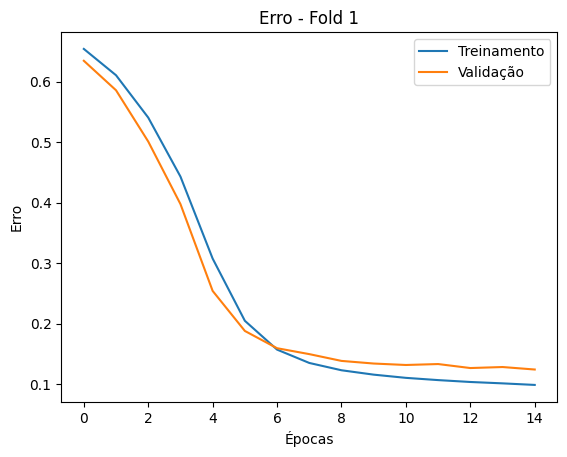

Fold 1
--> Acurácia Treino: 0.9668
--> Acurácia Validação: 0.9569
--> E_val - E_in = 0.0261
--> acc_in - acc_val = 0.0099



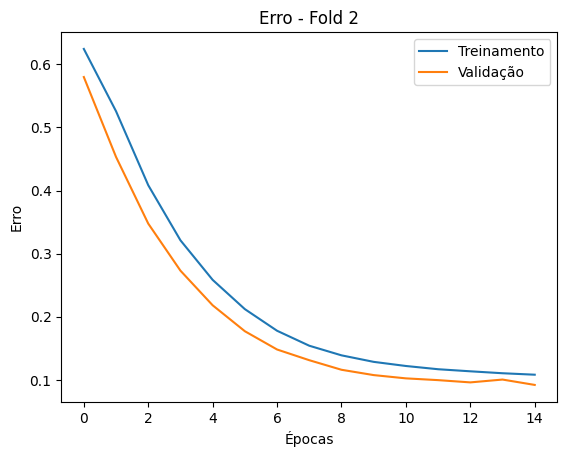

Fold 2
--> Acurácia Treino: 0.9651
--> Acurácia Validação: 0.9686
--> E_val - E_in = -0.0143
--> acc_in - acc_val = -0.0036



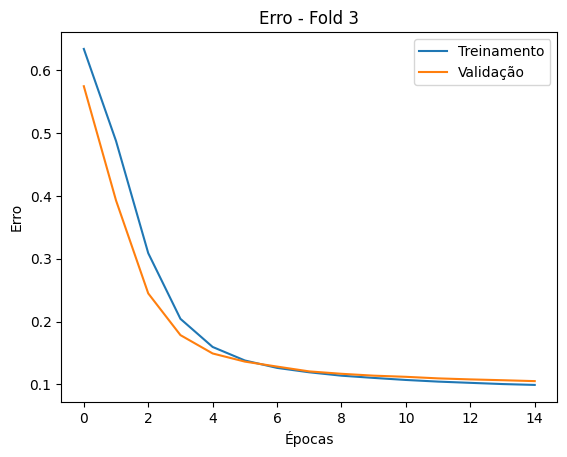

Fold 3
--> Acurácia Treino: 0.9674
--> Acurácia Validação: 0.9658
--> E_val - E_in = 0.0083
--> acc_in - acc_val = 0.0016



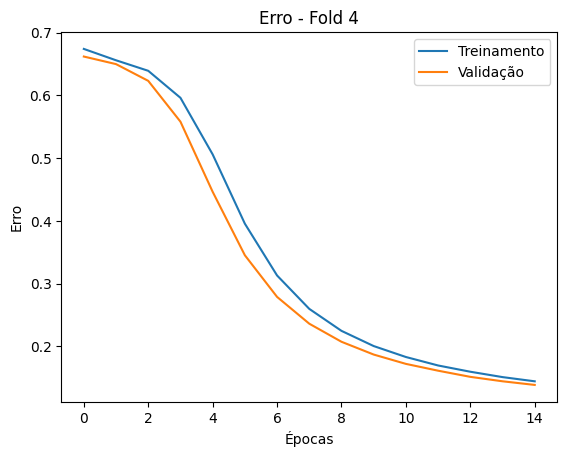

Fold 4
--> Acurácia Treino: 0.9601
--> Acurácia Validação: 0.9643
--> E_val - E_in = -0.0021
--> acc_in - acc_val = -0.0043



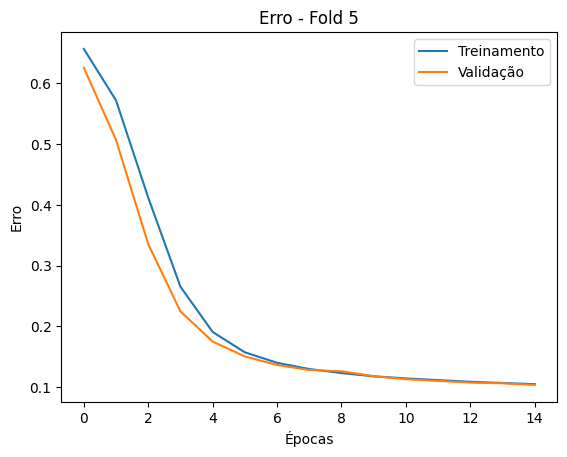

Fold 5
--> Acurácia Treino: 0.9645
--> Acurácia Validação: 0.9683
--> E_val - E_in = 0.0008
--> acc_in - acc_val = -0.0037



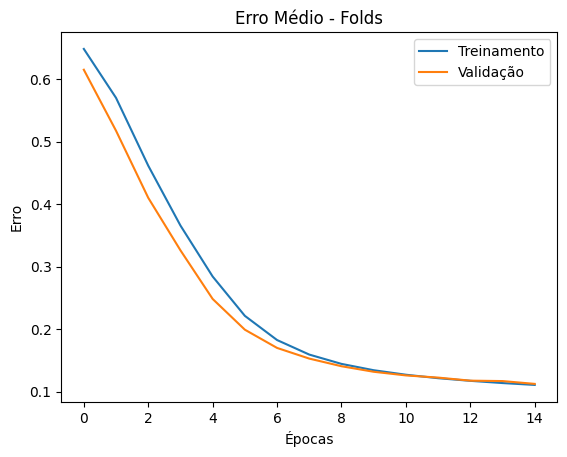

==== Resultado Final ====
--> Acurácia Média Treino: 0.9648
--> Acurácia Média Validação: 0.9648
--> (E_val - E_in) Médio: 0.0038
--> (acc_in - acc_val) Médio: -0.0000


In [124]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers, regularizers
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

X = df_final.drop(columns=["Email Type"]).values
y = df_final["Email Type"].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies_train = []
accuracies_val = []
history_list = []
ein_list = []
eval_list = []

BATCH_SIZE = 32
EPOCHS = 15  

input_dim = X_train.shape[1]  

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    model = Sequential()
    model.add(Dense(8, input_dim=input_dim, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(4, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(1, activation='sigmoid')) 

    optimizer = optimizers.SGD(learning_rate=0.01)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
                        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

    history_list.append(history)

    E_in, acc_train = model.evaluate(X_train_fold, y_train_fold, batch_size=BATCH_SIZE, verbose=0)
    E_val, acc_val = model.evaluate(X_val_fold, y_val_fold, batch_size=BATCH_SIZE, verbose=0)

    accuracies_train.append(acc_train)
    accuracies_val.append(acc_val)
    ein_list.append(E_in)
    eval_list.append(E_val)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Erro - Fold {fold}')
    plt.ylabel('Erro')
    plt.xlabel('Épocas')
    plt.legend(['Treinamento', 'Validação'])
    plt.show()

    print(f'Fold {fold}')
    print(f'--> Acurácia Treino: {acc_train:.4f}')
    print(f'--> Acurácia Validação: {acc_val:.4f}')
    print(f'--> E_val - E_in = {E_val - E_in:.4f}')
    print(f'--> acc_in - acc_val = {acc_train - acc_val:.4f}\n')

avg_acc_train = np.mean(accuracies_train)
avg_acc_val = np.mean(accuracies_val)
avg_ein = np.mean(ein_list)
avg_eval = np.mean(eval_list)

history_loss_avg = []
history_val_loss_avg = []

for epoch in range(EPOCHS):
    loss_epoch = np.mean([h.history['loss'][epoch] for h in history_list])
    val_loss_epoch = np.mean([h.history['val_loss'][epoch] for h in history_list])
    history_loss_avg.append(loss_epoch)
    history_val_loss_avg.append(val_loss_epoch)

plt.plot(history_loss_avg)
plt.plot(history_val_loss_avg)
plt.title('Erro Médio - Folds')
plt.ylabel('Erro')
plt.xlabel('Épocas')
plt.legend(['Treinamento', 'Validação'])
plt.show()

print("==== Resultado Final ====")
print(f'--> Acurácia Média Treino: {avg_acc_train:.4f}')
print(f'--> Acurácia Média Validação: {avg_acc_val:.4f}')
print(f'--> (E_val - E_in) Médio: {avg_eval - avg_ein:.4f}')
print(f'--> (acc_in - acc_val) Médio: {avg_acc_train - avg_acc_val:.4f}')


## Salvando modelo

In [125]:
import joblib
joblib.dump(model, 'modelo_phishing.pkl')  

loaded_model = joblib.load('modelo_phishing.pkl')  


In [126]:
loaded_model = joblib.load('modelo_phishing.pkl')